# PAE with SDSS Data

### step-by-step instructions for training a probabilsitic autoencoder with this package

In [32]:
# import this package 
from pytorch_pae import AE

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [34]:
# import pytorch
import torch

print(torch.__version__)

1.8.0


In [35]:
from torchsummary import summary

In [36]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Step 1: Choose your parameters

In [46]:
SEED          = 287505

## data parameters
dataset       = 'SDSS_DR16'
loc           = '/global/cscratch1/sd/vboehm/Datasets'
# number of layers in networks
n_layers     = 2

## convolutional net specific parameters
# number of channels in each layer for convolutional neural net
out_channels = [32]
# kernel sizes in each layer for conv net
kernel_sizes = [44]
# scaling factor in max pooling layer 
scale_facs   = [1] 
# padding values in each conv layer
paddings     = [0]
# stride values in each conv layer
strides      = [1]
# whether tp apply a layer normalization after conv layer
layer_norm   = [False,False]
# whether to train elemntwise affine parameters for normalization layer 
affine       = False

## fully connected net specific parameters
# output size of each fully connected layer
out_sizes    = [800,590]

## parameters that apply to both, fully connected and convolutional nets 
# dropout rate after each layer
dropout_rate = [0.0,0.0]
# whether to Lipschitz regularize by bounding the spectral norm 
spec_norm    = False
# activation function after each layer
activations  = ['ReLU','ReLU']
# whether to add a bias in each layer or not
bias         = [True,True]

## general parameters
# data dimensionality
dim          = '1D'
# latent space dimensionality
latent_dim   = 10
# number of channels in data
input_c      = 1 
# data dimensioality along one axis (only square data supported in 2D)
input_dim    = 1000
# type of encoder and decoder network (either 'fc' or 'conv')
encoder_type = 'fc'
decoder_type = 'fc'

# if True, the output is fed through a sigmoid layer to bring data values into range [0,1]
final_sigmoid = False


## Training parameters
nepochs          = 10
batchsize        = 32
batchsize_valid  = 512
initial_lr       = 1e-3

optimizer        = 'Adam'
criterion1       = 'masked_chi2'
criterion2       = 'masked_chi2'
contrastive      = False

scheduler        = 'ExponentialLR'
scheduler_params = {'gamma':0.98}
ann_epoch        = 5

In [47]:
general_params      = {'input_c': input_c, 'input_dim': input_dim, 'latent_dim': latent_dim, 'encoder_type': encoder_type,\
                       'decoder_type': decoder_type, 'dim': dim, 'contrastive':contrastive}
conv_network_params = {'n_layers': n_layers, 'out_channels': out_channels, 'kernel_sizes': kernel_sizes, 'scale_facs': scale_facs, 'paddings': paddings, \
                       'strides': strides,'activations': activations, 'spec_norm': spec_norm, 'layer_norm': layer_norm,\
                       'affine': affine,'final_sigmoid': final_sigmoid, 'bias':bias}
fc_network_params   = {'n_layers': n_layers, 'out_sizes': out_sizes,'activations': activations, 'spec_norm': spec_norm, 'dropout_rate':dropout_rate, \
                       'layer_norm': layer_norm, 'affine': affine, 'final_sigmoid': final_sigmoid, 'bias':bias}
training_params     = {'batchsize': batchsize, 'batchsize_valid': batchsize_valid, 'initial_lr': initial_lr, 'optimizer': optimizer, 'criterion1': criterion1, 'criterion2': criterion2,
                       'scheduler': scheduler, 'scheduler_params':scheduler_params, 'ann_epoch': ann_epoch}
data_params         = {'dataset':dataset, 'loc': loc}

In [48]:
torch.manual_seed(SEED)
np.random.seed(SEED)

## Step 2: Set up and train the autoencoder

In [49]:
AE1 = AE.Autoencoder(general_params,data_params,fc_network_params, fc_network_params, training_params, device)

In [50]:
if dim =='1D':
    summary(AE1, (input_c,input_dim))
else:
    summary(AE1, (input_c, input_dim, input_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 1000]               0
            Linear-2                  [-1, 800]         800,800
              ReLU-3                  [-1, 800]               0
           Dropout-4                  [-1, 800]               0
            Linear-5                  [-1, 590]         472,590
              ReLU-6                  [-1, 590]               0
           Dropout-7                  [-1, 590]               0
            Linear-8                   [-1, 10]           5,910
         FCEncoder-9                   [-1, 10]               0
          Flatten-10                   [-1, 10]               0
           Linear-11                  [-1, 590]           6,490
             ReLU-12                  [-1, 590]               0
          Dropout-13                  [-1, 590]               0
           Linear-14                  [

In [19]:
train_loss, valid_loss = AE1.train(nepochs)

epoch: 0, training loss: 3.0576e+00, validation loss: 1.7552e+00, learning rate: 9.8000e-04
epoch: 1, training loss: 1.6403e+00, validation loss: 1.6924e+00, learning rate: 9.6040e-04
epoch: 2, training loss: 1.5407e+00, validation loss: 1.4645e+00, learning rate: 9.4119e-04
epoch: 3, training loss: 1.4874e+00, validation loss: 1.4148e+00, learning rate: 9.2237e-04
epoch: 4, training loss: 1.4629e+00, validation loss: 1.4260e+00, learning rate: 9.0392e-04
epoch: 5, training loss: 1.4428e+00, validation loss: 1.4312e+00, learning rate: 8.8584e-04
epoch: 6, training loss: 1.4262e+00, validation loss: 1.4084e+00, learning rate: 8.6813e-04
epoch: 7, training loss: 1.4121e+00, validation loss: 1.3307e+00, learning rate: 8.5076e-04
epoch: 8, training loss: 1.4026e+00, validation loss: 1.3820e+00, learning rate: 8.3375e-04
epoch: 9, training loss: 1.4043e+00, validation loss: 1.3624e+00, learning rate: 8.1707e-04


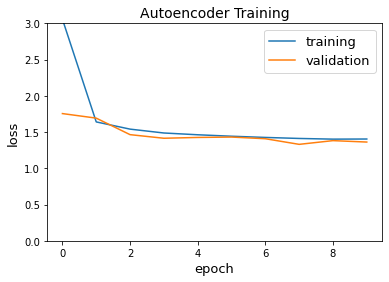

In [20]:
plt.figure()
plt.title('Autoencoder Training',fontsize=14)
plt.plot(train_loss, label='training')
plt.plot(valid_loss, label='validation')
plt.xlabel('epoch',fontsize=13)
plt.ylabel('loss',fontsize=13)
plt.legend(fontsize=13)
plt.ylim(0,3)
plt.show()

## Data reconstructions

In [21]:
from pytorch_pae.data_loader import *

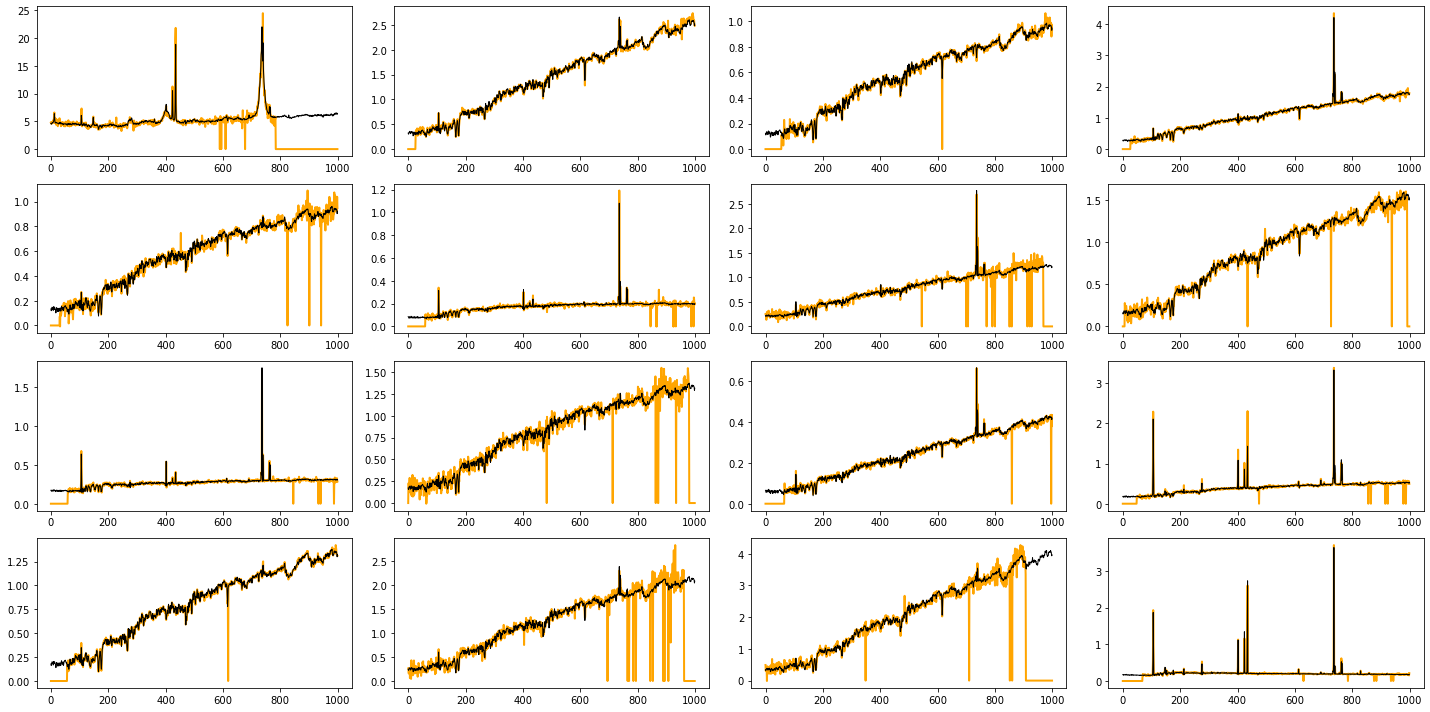

In [22]:
train_loader, valid_loader = get_data(data_params['dataset'],data_params['loc'],16, 16)

data  = next(iter(train_loader))
with torch.no_grad():
    recon = AE1.forward(data['features'].to(device).float())

fig, ax = plt.subplots(4,4,figsize=(20,10))
ax = ax.flatten()
for ii in range(16):
    ax[ii].plot(np.squeeze(data['features'][ii].cpu().detach().numpy()),lw=2, color='orange')
    ax[ii].plot(np.squeeze(recon[ii].cpu().detach().numpy()),lw=1,color='black')
    
plt.tight_layout()
plt.show()



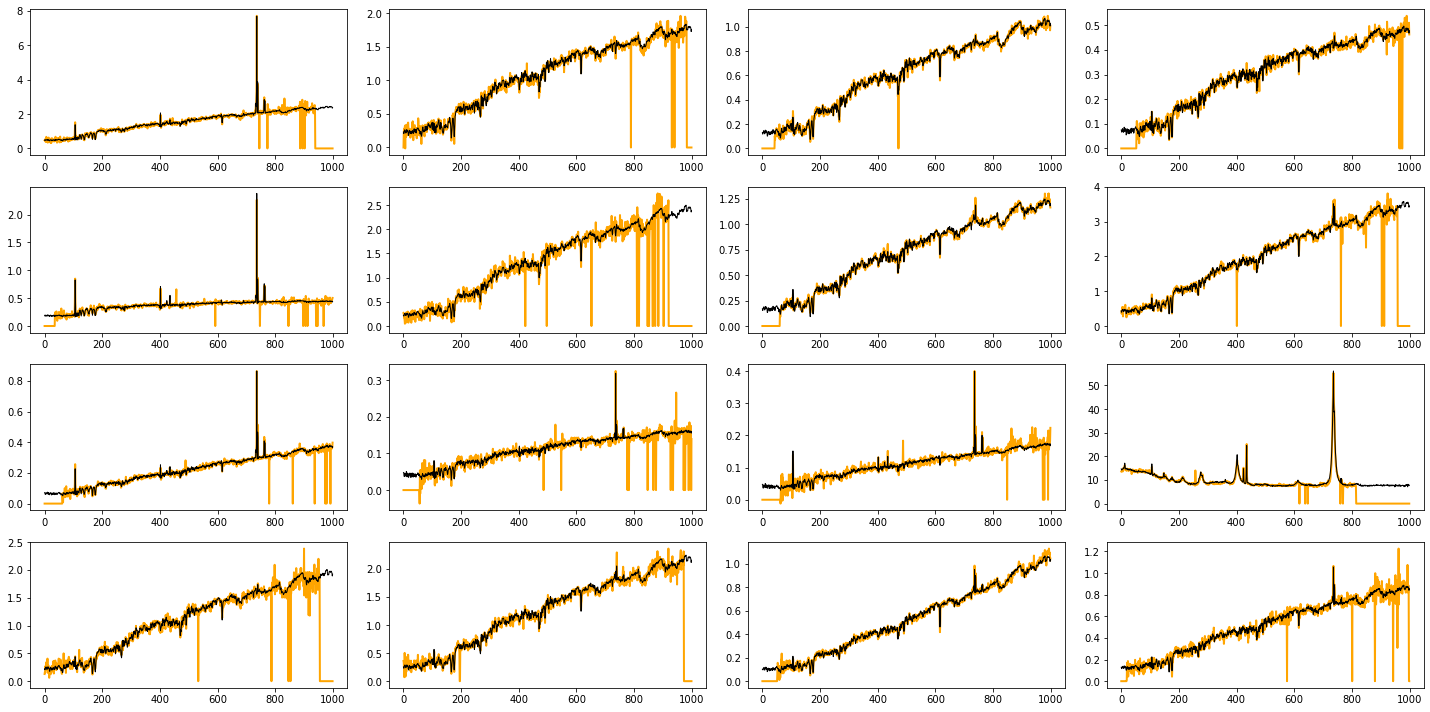

In [23]:
train_loader, valid_loader = get_data(data_params['dataset'],data_params['loc'],16, 16)

data  = next(iter(valid_loader))
with torch.no_grad():
    recon = AE1.forward(data['features'].to(device).float())

fig, ax = plt.subplots(4,4,figsize=(20,10))
ax = ax.flatten()
for ii in range(16):
    ax[ii].plot(np.squeeze(data['features'][ii].cpu().detach().numpy()),lw=2, color='orange')
    ax[ii].plot(np.squeeze(recon[ii].cpu().detach().numpy()),lw=1,color='black')
    
plt.tight_layout()
plt.show()

In [30]:
#torch.save(AE1, os.path.join('/global/cscratch1/sd/vboehm/Models/Tutorials', 'AE_SDSS_1'))

In [10]:
#AE1 = torch.load(os.path.join('/global/cscratch1/sd/vboehm/Models/Tutorials', 'AE_SDSS_1'))

In [24]:
AE1 = AE1.to('cpu')

In [25]:
def loss_by_wl(y_true, y_pred, device):
    loss           = (y_true['features'].to(device).float()-y_pred)**2*y_true['noise'].to(device).float()*y_true['mask'].to(device).float()
    valid_loss     = np.mean(loss.detach().cpu().numpy(),axis=0)
    std_valid_loss = np.std(loss.detach().cpu().numpy(),axis=0)
    return valid_loss, std_valid_loss

In [26]:
train_loader, valid_loader = get_data(data_params['dataset'],data_params['loc'],-1, -1)

data_train  = next(iter(train_loader))
data_valid  = next(iter(valid_loader))

In [27]:
with torch.no_grad():
    recon_valid = AE1.forward(data_valid['features'].float())
    recon_train = AE1.forward(data_train['features'].float())

In [28]:
recon_train

tensor([[[0.5796, 0.5438, 0.5563,  ..., 3.4529, 3.3936, 3.4145]],

        [[0.1050, 0.0995, 0.0941,  ..., 0.2546, 0.2473, 0.2542]],

        [[0.2231, 0.2054, 0.2186,  ..., 1.8932, 1.8511, 1.8831]],

        ...,

        [[0.2388, 0.2149, 0.2277,  ..., 1.7575, 1.7152, 1.7447]],

        [[0.0409, 0.0383, 0.0317,  ..., 0.2181, 0.2128, 0.2185]],

        [[0.3743, 0.3549, 0.3784,  ..., 3.9220, 3.8579, 3.8954]]])

In [29]:
root_encoded     = '/global/cscratch1/sd/vboehm/Datasets/encoded/sdss/'
root_decoded     = '/global/cscratch1/sd/vboehm/Datasets/decoded/sdss/'


wlmin, wlmax    = (3388,8318)
fixed_num_bins  = 1000
min_SN          = 50
min_z           = 0.05
max_z           = 0.36
label           = 'galaxies_quasars_bins%d_wl%d-%d'%(fixed_num_bins,wlmin,wlmax)
label_          = label+'_minz%s_maxz%s_minSN%d'%(str(int(min_z*100)).zfill(3),str(int(max_z*100)).zfill(3),min_SN)
label_2         = label_+'_10_fully_connected_mean_div'



#np.save(os.path.join(root_decoded,'decoded_%s_conv.npy'%(label_2)),[recon_train.numpy(), recon_valid.numpy()])

In [30]:
recon_valid.shape, recon_train.shape

(torch.Size([69822, 1, 1000]), torch.Size([209462, 1, 1000]))

In [31]:
recon_error = loss_by_wl(data_valid, recon, device='cpu')

RuntimeError: The size of tensor a (69822) must match the size of tensor b (16) at non-singleton dimension 0

In [ ]:
wlmin, wlmax    = (3388,8318)
wl_range        = (np.log10(wlmin),np.log10(wlmax))
# new binning 
new_wl          = np.logspace(wl_range[0],wl_range[1],input_dim)

In [ ]:
plotpath        = '/global/homes/v/vboehm/codes/SDSS_PAE/figures'
plt.plot(new_wl,np.squeeze(recon_error[0]/np.mean(data_valid['mask'].detach().cpu().numpy(),axis=0)-1),color='navy')
plt.xlabel(r'restframe $\lambda$ [nm]')
plt.ylabel('pixelwise $\chi^2$ -1')
plt.grid()
plt.tight_layout()
#plt.ylim(0,2.5)
#plt.savefig(os.path.join(plotpath,'mean_reconstruction_error_convAE1.pdf'), bbox_inches='tight')

In [ ]:
with torch.no_grad():
    #encoded_train = AE1.encoder.forward(data_train['features'].float()).numpy()
    encoded_valid = AE1.encoder.forward(data_valid['features'].float()).numpy()

In [ ]:

#np.save(os.path.join(root_encoded,'encoded_%s_conv.npy'%(label_2)),[encoded_train, encoded_valid])

In [ ]:
lims = 50

fig, ax = plt.subplots(2,latent_dim//2, figsize=(20,6))
ax=ax.flatten()
for ii in range(latent_dim):
    jj= (ii+1)%latent_dim
    im = ax[ii].scatter(encoded_valid[:,ii],encoded_valid[:,jj],c=data['subclass'], cmap='jet', s=4)
    ax[ii].set_xlim(max(min(encoded_valid[:,ii]),-lims),min(max(encoded_valid[:,ii]),lims))
    ax[ii].set_ylim(max(min(encoded_valid[:,jj]),-lims),min(max(encoded_valid[:,jj]),lims))
    ax[ii].set_xlabel('dim %d'%ii)
    ax[ii].set_ylabel('dim %d'%jj)
    #plt.colorbar(im, ax=ax[ii])
plt.tight_layout()
#plt.savefig(os.path.join(plotpath,'encoded_valid_subclass_convAE1.pdf'), bbox_inches='tight')
plt.show()

In [ ]:
lims = 50

fig, ax = plt.subplots(2,latent_dim//2, figsize=(20,6))
ax=ax.flatten()
for ii in range(latent_dim):
    jj= (ii+1)%latent_dim
    im = ax[ii].scatter(encoded_valid[:,ii],encoded_valid[:,jj],c=data['z'], cmap='jet',s=4)
    ax[ii].set_xlim(max(min(encoded_valid[:,ii]),-lims),min(max(encoded_valid[:,ii]),lims))
    ax[ii].set_ylim(max(min(encoded_valid[:,jj]),-lims),min(max(encoded_valid[:,jj]),lims))
    ax[ii].set_xlabel('dim %d'%ii)
    ax[ii].set_ylabel('dim %d'%jj)
    plt.colorbar(im, ax=ax[ii])
plt.tight_layout()
#plt.savefig(os.path.join(plotpath,'encoded_valid_redshift_convAE1.pdf'), bbox_inches='tight')
plt.show()

In [53]:
recon.shape, encoded_valid.shape

(torch.Size([69820, 1, 1000]), (69820, 10))